In [155]:
#!/usr/bin/python
import json
import sys
from operator import itemgetter
from os import listdir
from os.path import isfile, join, isdir
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

In [156]:
fig_width = 8
fig_height = 5

params = {
    'axes.labelsize': 16, # fontsize for x and y labels (was 10)
    'axes.titlesize': 16,
    'legend.fontsize': 16, # was 10
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'text.usetex': False,
    'figure.figsize': [fig_width,fig_height],
    'font.family': 'serif',
    'grid.linestyle': '--',
    'lines.linewidth': 2
}

matplotlib.rcParams.update(params)

In [129]:
def collectStatistics(analyze_app, event_dir='/tmp/spark-events', memory_dir='/tmp/spark-memory'):   
    
    file_names = []
    iterations = []
    captions = ["Iteration",
                "Incremental Start",
                "Incremental End",
                "Incremental Duration",
                "Batch Start",
                "Batch End",
                "Batch Duration", 
                'Memory Min', 
                'Memory Max', 
                'Memory Mean', 'direct-used']

    data_frame = pd.DataFrame(columns=captions)
    data_frame.set_index('Iteration')

    onlyfiles = [f for f in listdir(event_dir) if isfile(join(event_dir, f)) and 'inprogress' not in f]

    for file in onlyfiles:
        with open(join(event_dir, file)) as f:
            
            content = f.readlines()
            batch_computation = False
            iteration_number = -1
            for line in content:
                event = json.loads(line)

                if event['Event'] == 'SparkListenerEnvironmentUpdate':
                    app_name = event['Spark Properties']['spark.app.name']
                    if app_name.startswith(analyze_app):
                        version = app_name.replace(analyze_app, '')
                        if not version:
                            version = '0'
                        if '_batch_' in version:
                            batch_computation = True
                            iteration_number = int(version.replace('_batch_', ''))
                            if data_frame.loc[data_frame['Iteration'] == iteration_number].empty:
                                data_frame.loc[len(data_frame)] = iteration_number

                        else:
                            batch_computation = False
                            iteration_number = int(version)
                            if data_frame.loc[data_frame['Iteration'] == iteration_number].empty:
                                data_frame.loc[len(data_frame)] = iteration_number




                if event['Event'] == 'SparkListenerJobStart':
                    start = event['Submission Time']
                    caption = 'Incremental Start'
                    if batch_computation:
                        caption = 'Batch Start'

                    data_frame.loc[data_frame['Iteration'] == iteration_number, caption] = start

                if event['Event'] == 'SparkListenerJobEnd':
                    end = event['Completion Time']
                    caption = 'Incremental End'
                    if batch_computation:
                        caption = 'Batch End'
                    data_frame.loc[data_frame['Iteration'] == iteration_number, caption] = end
                    
            if isdir(memory_dir) and iteration_number >= 0:
                file_names.append(file)
                iterations.append(iteration_number)
                """
                 '.driver.jvm.heap.committed.csv',
                 '.driver.jvm.heap.init.csv',
                 '.driver.jvm.heap.max.csv',
                 '.driver.jvm.heap.usage.csv',
                 '.driver.jvm.heap.used.csv',
                 .driver.BlockManager.memory.memUsed_MB.csv
                """
                #mem_df = pd.read_csv(join(memory_dir, file + '.driver.jvm.heap.used.csv'))
                #mem_df = pd.read_csv(join(memory_dir, file + '.driver.jvm.heap.usage.csv'))
                try:
                    mem_df = pd.read_csv(join(memory_dir, file + '.driver.BlockManager.memory.memUsed_MB.csv'))
                    data_frame.loc[data_frame['Iteration'] == iteration_number, 'Memory Min'] = mem_df['value'].min()
                    data_frame.loc[data_frame['Iteration'] == iteration_number, 'Memory Max'] = mem_df['value'].max()
                    data_frame.loc[data_frame['Iteration'] == iteration_number, 'Memory Mean'] = mem_df['value'].mean()
                    mem_df2 = pd.read_csv(join(memory_dir, file + '.driver.jvm.direct.used.csv'))
                    data_frame.loc[data_frame['Iteration'] == iteration_number, 'direct-used'] = mem_df2['value'].mean()
                except:
                    continue
                
    data_frame['Incremental Duration'] = data_frame['Incremental End'] - data_frame['Incremental Start']
    data_frame['Batch Duration'] = data_frame['Batch End'] - data_frame['Batch Start']

    data_frame = data_frame.sort_values(['Iteration'], ascending=[True])
    data_frame = data_frame.set_index('Iteration')
    return data_frame, file_names, iterations

In [130]:
def collect_logs(log_dir, app_name, suffixes=[]):
    for suffix in suffixes:
        test_name = app_name + suffix
        in_dir = join(log_dir, test_name)
        #onlyfiles = [f for f in listdir(in_dir) if isfile(join(in_dir, f))]
        update_frame = pd.read_csv(join(in_dir, test_name + '-update-time-and-space.csv')) 
        #display(update_frame.head())
        #plot_nice(update_frame, ' Sec. Index Memory Size (bytes)', y_label='Object Size (MB)', scale_function=lambda x: x / 1024 / 1024)
        return update_frame

In [131]:
def get_sizeframe(dataset_dir):

    onlyfiles = [f for f in listdir(dataset_dir) if isfile(join(dataset_dir, f)) and f.endswith(".txt")]
    onlyfiles = sorted(onlyfiles)

    edgecounts = {}
    sizes = {}
    unzipped_sizes = {}
    tmp = 0
    for filename in onlyfiles:
        # first line: number of types in dataset (not unique)
        # second line: number of edges in dataset (not unique)
        # third line size bytes
        f = open(join(dataset_dir,filename), 'r')
        content = f.read().split('\n')
        #print(len(content))
        if len(content) > 2:
            edges = int(content[1])
        else:
            edges = int(content[0])

        size = int(content[2])

        if len(content) > 4:
            unzipped_size = int(content[3])

        if 'iteration' in filename:
            iteration = filename.replace('iteration', '')
            iteration = iteration.replace('-', '')
            iteration = iteration.replace('.txt', '')
            iteration = iteration.replace('.gz', '')
            iteration = iteration.replace('.nq', '')
            iteration = iteration.replace('.nt', '')

            edgecounts[int(iteration)] = edges
            sizes[int(iteration)] = size
            if len(content) > 4:
                unzipped_sizes[int(iteration)] = unzipped_size

        else:
            edgecounts[tmp] = edges
            sizes[tmp] = size
            if len(content) > 4:
                unzipped_sizes[tmp] = unzipped_size
            tmp = tmp + 1

    edgeframe = pd.DataFrame.from_dict(edgecounts, orient='index')
    edgeframe = pd.DataFrame.sort_index(edgeframe)

    if len(content) > 4:
        sizeframe = pd.DataFrame.from_dict(unzipped_sizes, orient='index')
    else:
        sizeframe = pd.DataFrame.from_dict(sizes, orient='index')

    sizeframe = pd.DataFrame.sort_index(sizeframe)

    if 'DyLDO-core' in dataset_dir:    
        edgeframe = edgeframe.drop(edgeframe.index[[21,22]])
        sizeframe = sizeframe.drop(sizeframe.index[[21,22]])
        print('drop the beat')

    sizeframe = sizeframe.applymap(lambda x: x / 1024 / 1024) 
    if len(content) <= 4:
        sizeframe = sizeframe.applymap(lambda x: x * 15) 

    sizeframe.columns=['Data Graph (Disk)']
    return sizeframe

In [132]:
out_dir = join('..', 'plots', 'memory_exp')
event_dir = join('..', 'data', 'spark_logs-memory_exp')
memory_dir = join(event_dir, 'spark-memory')
exp_log_dir = join('..', 'data', 'exp_logs-memory_exp', 'experiments')


In [133]:
data_dir = join('..', 'data', 'dataset_data')

app_name = 'BSBM-type-memory'
#app_name = 'BSBM-schemex-memory'
#app_name = 'BSBM-attribute-memory'
app_name = 'DyLDO-core-attribute-memory'
app_name = 'DyLDO-core-schemex-memory'
app_name = 'DyLDO-core-type-memory'

data_size_dir = 'BSBM'
data_size_dir = 'DyLDO-core'

suffix = '-test-2' 
#suffix = '-test-1'

In [107]:
performance_frame, used_files, iterations = collectStatistics('%s%s' % (app_name, suffix), event_dir, memory_dir)

In [108]:
update_frame = collect_logs(exp_log_dir, app_name, suffixes=[suffix])

In [109]:
size_frame = get_sizeframe(join(data_dir, data_size_dir))

drop the beat


In [110]:
memory_frame = pd.DataFrame()
memory_frame['Data Graph (Disk)'] = size_frame['Data Graph (Disk)']
memory_frame['Max Spark Memory'] = performance_frame['Memory Max']
memory_frame['Mean Spark Memory'] = performance_frame['Memory Mean']
memory_frame['VHI Memory'] = update_frame[' Sec. Index Memory Size (bytes)'].apply(lambda x: x / 1024 / 1024) 
#memory_frame = memory_frame.dropna()
display(memory_frame.head())

,Data Graph (Disk),Max Spark Memory,Mean Spark Memory,VHI Memory
0,2405.307897,10820,7213.333333,914.277344
1,2306.354592,10462,6974.666667,862.612572
2,2790.347591,12831,9623.25,962.288483
3,2722.321526,12454,9340.5,958.607307
4,2383.698988,10772,7181.333333,917.991615


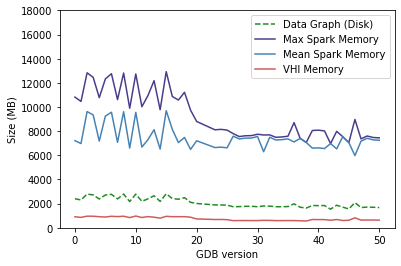

In [111]:
'''
     ('solid', 'solid'),      # Same as (0, ()) or '-'
     ('dotted', 'dotted'),    # Same as (0, (1, 1)) or '.'
     ('dashed', 'dashed'),    # Same as '--'
     ('dashdot', 'dashdot')]  # Same as '-.'
'''
ax = memory_frame.plot(logy=False, style=['--', '-', '-', '-'], color=['forestgreen', 'darkslateblue', 'steelblue', 'indianred'])



ax.set_ylabel("Size (MB)")
ax.legend(loc='upper right')
ax.set_xlabel("GDB version")
ax.set_ylim([0, 18000])

plt.savefig(out_dir + '/' + app_name + '.pdf', bbox_inches = 'tight')    
plt.savefig(out_dir + '/' + app_name + '.png', bbox_inches = 'tight', dpi=300)   

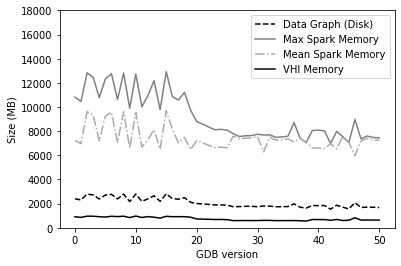

In [112]:
ax_bw = memory_frame.plot(logy=False, style=['--', '-', '-.'], color=['black', 'grey', 'darkgrey'])

ax_bw.set_ylabel("Size (MB)")
ax_bw.legend(loc='upper right')
ax_bw.set_xlabel("GDB version")
ax_bw.set_ylim([0, 18000])


plt.savefig(out_dir + '/' + app_name + '_bw.pdf', bbox_inches = 'tight')    
plt.savefig(out_dir + '/' + app_name + '_bw.png', bbox_inches = 'tight', dpi=300)   

In [113]:
out_dir

'../plots/memory_exp'

In [114]:
print(app_name)
print('VHI size is between %.4f and %.4f (mean: %.4f +- %.4f)' % (memory_frame['VHI Memory'].min(), 
                                                                  memory_frame['VHI Memory'].max(), 
                                                                  memory_frame['VHI Memory'].mean(), 
                                                                  memory_frame['VHI Memory'].std()))


DyLDO-core-type-memory
VHI size is between 559.4413 and 974.0381 (mean: 749.6954 +- 144.6661)


#### BSBM-attribute-memory
VHI size is between 1.8496 and 323.8004 (mean: 158.8012 +- 96.7929)

#### BSBM-type-memory
VHI size is between 1.8415 and 323.8541 (mean: 158.8290 +- 96.8124)

#### BSBM-schemex-memory
VHI size is between 1.8783 and 325.8255 (mean: 159.9176 +- 97.4039)

------

#### DyLDO-core-attribute-memory
VHI size is between 560.6463 and 975.5345 (mean: 755.1824 +- 146.2962)

#### DyLDO-core-type-memory
VHI size is between 559.4413 and 974.0381 (mean: 749.6954 +- 144.6661)

#### DyLDO-core-schemex-memory
VHI size is between 568.9798 and 983.9965 (mean: 759.4240 +- 144.7595)

In [18]:
overhead = memory_frame.dropna()['VHI Memory'] / memory_frame.dropna()['Max Spark Memory']
#display(overhead)
print(app_name)
print('memory overhead is between %.4f and %.4f (mean: %.4f +- %.4f)' % (overhead.min(), 
                                                                         overhead.max(), 
                                                                         overhead.mean(), 
                                                                         overhead.std()))

BSBM-attribute-memory
memory overhead is between 0.0213 and 0.0240 (mean: 0.0221 +- 0.0006)


#### BSBM-attribute-memory
memory overhead is between 0.0213 and 0.0240 (mean: 0.0221 +- 0.0006)

#### BSBM-type-memory
memory overhead is between 0.0213 and 0.0240 (mean: 0.0221 +- 0.0006)

#### BSBM-schemex-memory
memory overhead is between 0.0215 and 0.0244 (mean: 0.0223 +- 0.0007)

------

#### DyLDO-core-attribute-memory
memory overhead is between 0.0621 and 0.1127 (mean: 0.0826 +- 0.0093)

#### DyLDO-core-type-memory
memory overhead is between 0.0687 and 0.0923 (mean: 0.0817 +- 0.0052)

#### DyLDO-core-schemex-memory
memory overhead is between 0.0698 and 0.0939 (mean: 0.0828 +- 0.0052)


In [ ]:
disk_vs_memory = memory_frame['Spark Memory'] / memory_frame['Data Graph (Disk)']
print(app_name)
print('Memory per Disk space: %s (+- %s)' % (round(disk_vs_memory.mean(), 2), round(disk_vs_memory.std(), 2)))

#### BSBM-attribute-memory
Memory per Disk space: 4.23 (+- 0.06)

#### BSBM-type-memory
Memory per Disk space: 4.23 (+- 0.06)

#### BSBM-schemex-memory
Memory per Disk space: 4.23 (+- 0.06)

----

#### DyLDO-core-attribute-memory
Memory per Disk space: 4.43 (+- 0.11)

#### DyLDO-core-type-memory
Memory per Disk space: 4.43 (+- 0.11)

#### DyLDO-core-schemex-memory
Memory per Disk space: 4.43 (+- 0.11)




In [134]:
data_dir = join('..', 'data', 'dataset_data')

bsbm_apps = ['BSBM-schemex-memory', 'BSBM-attribute-memory', 'BSBM-type-memory']
dyldo_apps = ['DyLDO-core-attribute-memory', 'DyLDO-core-schemex-memory', 'DyLDO-core-type-memory']



bsbm_size_dir = 'BSBM'
dyldo_size_dir = 'DyLDO-core'
suffix = '-test-2'

In [148]:
def dataset_models(app_names, data_size_dir):
    memory_frame = pd.DataFrame()
    size_frame = get_sizeframe(join(data_dir, data_size_dir))

    memory_frame['Data Graph (Disk)'] = size_frame['Data Graph (Disk)']

    for app_name in app_names:

        performance_frame, filenames, iterations = collectStatistics('%s%s' % (app_name, suffix), event_dir, memory_dir)
        update_frame = collect_logs(exp_log_dir, app_name, suffixes=[suffix])

        # verified beforehand that all values are exactly equal!
        if 'Max Spark Memory' not in memory_frame.columns:
            memory_frame['Max Spark Memory'] = performance_frame['Memory Max']

        if 'schemex' in app_name:
            display_name = 'SchemEX'
        if 'type' in app_name:
            display_name = 'ClassColl'
        if 'attribute' in app_name:
            display_name = 'AttrColl'
            
        memory_frame['%s:Mean Spark Memory' % display_name] = performance_frame['Memory Mean']

        memory_frame['%s:VHI Memory' % display_name] = update_frame[' Sec. Index Memory Size (bytes)'].apply(lambda x: x / 1024 / 1024) 
    return memory_frame


def plot_multiple(memory_frame, dataset, hide_legend=False):
    '''
     ('solid', 'solid'),      # Same as (0, ()) or '-'
     ('dotted', 'dotted'),    # Same as (0, (1, 1)) or '.'
     ('dashed', 'dashed'),    # Same as '--'
     ('dashdot', 'dashdot')]  # Same as '-.'
    '''
    ax = memory_frame.plot(logy=False, style=['-.', '-', '-', '--', '-', '--', '-', '--'], 
                                color=['gray', 'black', 'darkslateblue', 'darkslateblue', 'forestgreen', 'forestgreen', 'indianred', 'indianred'])



    ax.set_ylabel("Size (MB)")
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), shadow=True, ncol=4)
    ax.set_xlabel("GDB version")
    ax.set_ylim([0, 18000])
    plt.grid(True)
    if hide_legend:
        ax.get_legend().remove()
        
    plt.savefig(out_dir + '/' + dataset + '-memory.pdf', bbox_inches = 'tight')    
    plt.savefig(out_dir + '/' + dataset + '-memory.png', bbox_inches = 'tight', dpi=300)   

In [149]:
bsbm_memory_frame = dataset_models(bsbm_apps, bsbm_size_dir)
display(bsbm_memory_frame.head()) 

,Data Graph (Disk),Max Spark Memory,SchemEX:Mean Spark Memory,SchemEX:VHI Memory,AttrColl:Mean Spark Memory,AttrColl:VHI Memory,ClassColl:Mean Spark Memory,ClassColl:VHI Memory
0,18.324519,77,77.0,1.878326,77.0,1.849579,77.0,1.841476
1,177.418148,755,755.0,17.335678,755.0,17.119522,755.0,17.055000
2,352.412623,1439,1439.0,33.760101,1439.0,33.433716,1439.0,33.441544
3,530.224883,2282,2282.0,50.995590,2282.0,50.381363,2282.0,50.400909
4,703.383891,2995,2995.0,66.934441,2995.0,66.266380,2995.0,66.285973


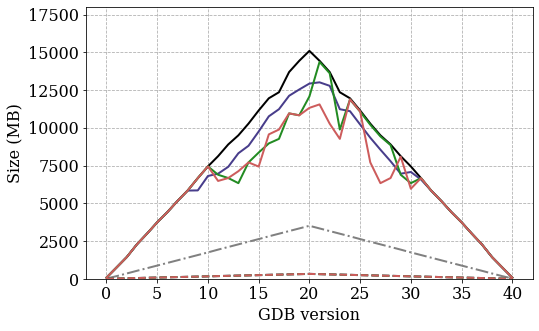

In [157]:
plot_multiple(bsbm_memory_frame, bsbm_size_dir, hide_legend=True)

In [172]:
tf = pd.DataFrame()
tf['VHI Memory'] = bsbm_memory_frame['SchemEX:VHI Memory'].append(bsbm_memory_frame['AttrColl:VHI Memory']).append(bsbm_memory_frame['ClassColl:VHI Memory'])
tf['Max Spark Memory'] = bsbm_memory_frame['Max Spark Memory'].append(bsbm_memory_frame['Max Spark Memory']).append(bsbm_memory_frame['Max Spark Memory'])
overhead = tf['VHI Memory'] / tf['Max Spark Memory']
print('BSBM memory overhead is between %.4f and %.4f (mean: %.4f +- %.4f)' % (overhead.min(), 
                                                                         overhead.max(), 
                                                                         overhead.mean(), 
                                                                         overhead.std()))

import statistics

asd = [bsbm_memory_frame.loc[20]['AttrColl:VHI Memory'], bsbm_memory_frame.loc[20]['ClassColl:VHI Memory'], bsbm_memory_frame.loc[20]['SchemEX:VHI Memory']]
print(statistics.mean(asd))
print(statistics.stdev(asd))

BSBM memory overhead is between 0.0213 and 0.0244 (mean: 0.0222 +- 0.0006)
324.4933319091797
1.1539650805687942


In [159]:
dyldo_memory_frame = dataset_models(dyldo_apps, dyldo_size_dir)
display(dyldo_memory_frame.head()) 

drop the beat


,Data Graph (Disk),Max Spark Memory,AttrColl:Mean Spark Memory,AttrColl:VHI Memory,SchemEX:Mean Spark Memory,SchemEX:VHI Memory,ClassColl:Mean Spark Memory,ClassColl:VHI Memory
0,2405.307897,10820,8115.0,915.605110,8115.0,924.032837,7213.333333,914.277344
1,2306.354592,10462,10428.467949,863.867897,7846.5,872.276924,6974.666667,862.612572
2,2790.347591,12831,11664.545455,963.562141,9623.25,971.988815,9623.25,962.288483
3,2722.321526,12454,11496.0,959.856270,9340.5,968.275116,9340.5,958.607307
4,2383.698988,10772,7181.333333,919.239250,8079.0,927.657135,7181.333333,917.991615


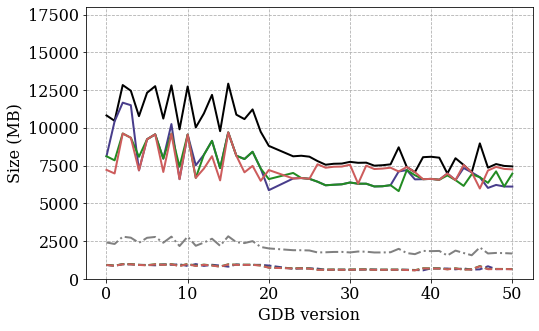

In [158]:
plot_multiple(dyldo_memory_frame, dyldo_size_dir, hide_legend=True)

In [170]:
tf = pd.DataFrame()
tf['VHI Memory'] = dyldo_memory_frame['SchemEX:VHI Memory'].append(dyldo_memory_frame['AttrColl:VHI Memory']).append(dyldo_memory_frame['ClassColl:VHI Memory'])
tf['Max Spark Memory'] = dyldo_memory_frame['Max Spark Memory'].append(dyldo_memory_frame['Max Spark Memory']).append(dyldo_memory_frame['Max Spark Memory'])
overhead = tf['VHI Memory'] / tf['Max Spark Memory']
print('DyLDO-core memory overhead is between %.4f and %.4f (mean: %.4f +- %.4f)' % (overhead.min(), 
                                                                         overhead.max(), 
                                                                         overhead.mean(), 
                                                                         overhead.std()))

import statistics

asd = [dyldo_memory_frame.loc[36]['AttrColl:VHI Memory'], dyldo_memory_frame.loc[36]['ClassColl:VHI Memory'], dyldo_memory_frame.loc[36]['SchemEX:VHI Memory']]
print(statistics.mean(asd))
print(statistics.stdev(asd))

DyLDO-core memory overhead is between 0.0621 and 0.1127 (mean: 0.0823 +- 0.0068)
602.3551508585612
4.944330402236946


In [41]:
bsbm_memory_frame[bsbm_memory_frame['BSBM-attribute-memory:Spark Memory'] != bsbm_memory_frame['BSBM-schemex-memory:Spark Memory']]

,Data Graph (Disk),BSBM-schemex-memory:Spark Memory,BSBM-schemex-memory:VHI Memory,BSBM-attribute-memory:Spark Memory,BSBM-attribute-memory:VHI Memory,BSBM-type-memory:Spark Memory,BSBM-type-memory:VHI Memory


In [42]:
bsbm_memory_frame[bsbm_memory_frame['BSBM-attribute-memory:Spark Memory'] != bsbm_memory_frame['BSBM-type-memory:Spark Memory']]

,Data Graph (Disk),BSBM-schemex-memory:Spark Memory,BSBM-schemex-memory:VHI Memory,BSBM-attribute-memory:Spark Memory,BSBM-attribute-memory:VHI Memory,BSBM-type-memory:Spark Memory,BSBM-type-memory:VHI Memory


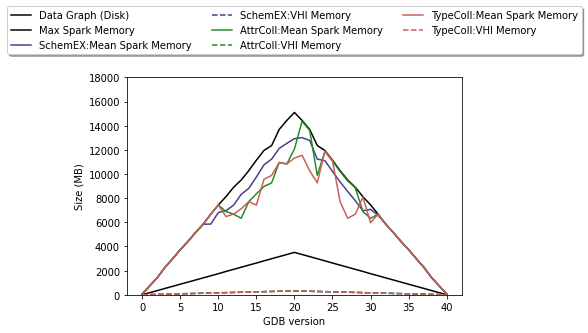

In [ ]:
dyldo_memory_frame = pd.DataFrame()
size_frame = get_sizeframe(join(data_dir, dyldo_size_dir))

dyldo_memory_frame['Data Graph (Disk)'] = size_frame['Data Graph (Disk)']

dyldo_files = []
for app_name in dyldo_apps:
    
    performance_frame, filenames, iterations = collectStatistics('%s%s' % (app_name, suffix), event_dir, memory_dir)
    update_frame = collect_logs(exp_log_dir, app_name, suffixes=[suffix])
    dyldo_files.append(filenames)
    
    #dyldo_memory_frame['%s:Spark Memory' % app_name] = performance_frame['Memory Mean']
    dyldo_memory_frame['%s:VHI Memory' % app_name] = update_frame[' Sec. Index Memory Size (bytes)'].apply(lambda x: x / 1024 / 1024) 

display(dyldo_memory_frame)

In [ ]:
set(dyldo_files[1]) & set(dyldo_files[2]) 

In [ ]:
dyldo_memory_frame[dyldo_memory_frame['DyLDO-core-attribute-memory:Spark Memory'] != dyldo_memory_frame['DyLDO-core-schemex-memory:Spark Memory']]

In [ ]:
dyldo_memory_frame[dyldo_memory_frame['DyLDO-core-attribute-memory:Spark Memory'] != dyldo_memory_frame['DyLDO-core-type-memory:Spark Memory']]